## Import

In [71]:
import sys
import os
import tensorflow as tf
import numpy as np
#import tensorflow_probability as tfp

# Manually making sure the numpy random seeds are "the same" on all devices
np.random.seed(1)
tf.set_random_seed(1)
tf.enable_eager_execution()

In [40]:
import scipy.io
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from datetime import datetime
from pyDOE import lhs
import os
import sys
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Prepare data from pendulum dataset (default sample size is 1000)

In [41]:
def prep_data_2d(pendulum):
    NSAMPLE = int(pendulum.size/3)
    th = np.arcsin(pendulum[1])
    thdot = pendulum[2]
    dt = 0.05
    t_total = dt*NSAMPLE
    T = np.linspace(dt,t_total, NSAMPLE)
    
    ##reshape the theta, thdot and t
    th = np.array(th).reshape(1, -1).T
    thdot = np.array(thdot).reshape(1, -1).T
    T = np.array(T).reshape(1, -1).T
    
    X_star = np.hstack((thdot,T))
    u_star = th
    lb = X_star.min(axis=0)
    ub = X_star.max(axis=0)
    X_f_train = lb + (ub-lb)*lhs(2, N_f)
    
    idx = np.random.choice(X_star.shape[0], N_u, replace=False)
    X_u_train = X_star[idx,:]
    u_train = u_star[idx,:]
    
    return X_star, u_star, X_u_train, u_train, X_f_train, ub, lb

In [42]:
class Logger(object):
  def __init__(self, frequency=10):
    print("TensorFlow version: {}".format(tf.__version__))
    print("Eager execution: {}".format(tf.executing_eagerly()))
    print("GPU-accerelated: {}".format(tf.test.is_gpu_available()))

    self.start_time = time.time()
    self.frequency = frequency

  def __get_elapsed(self):
    return datetime.fromtimestamp(time.time() - self.start_time).strftime("%M:%S")

  def __get_error_u(self):
    return self.error_fn()

  def set_error_fn(self, error_fn):
    self.error_fn = error_fn
  
  def log_train_start(self, model):
    print("\nTraining started")
    print("================")
    self.model = model
    print(self.model.summary())

  def log_train_epoch(self, epoch, loss, custom="", is_iter=False):
    if epoch % self.frequency == 0:
      print(f"{'nt_epoch' if is_iter else 'tf_epoch'} = {epoch:6d}  elapsed = {self.__get_elapsed()}  loss = {loss:.4e}  error = {self.__get_error_u():.4e}  " + custom)

  def log_train_opt(self, name):
    # print(f"tf_epoch =      0  elapsed = 00:00  loss = 2.7391e-01  error = 9.0843e-01")
    print(f"—— Starting {name} optimization ——")

  def log_train_end(self, epoch, custom=""):
    print("==================")
    print(f"Training finished (epoch {epoch}): duration = {self.__get_elapsed()}  error = {self.__get_error_u():.4e}  " + custom)

In [43]:
# Adapted from https://github.com/yaroslavvb/stuff/blob/master/eager_lbfgs/eager_lbfgs.py

import tensorflow as tf
import numpy as np
import time

# Time tracking functions
global_time_list = []
global_last_time = 0
def reset_time():
  global global_time_list, global_last_time
  global_time_list = []
  global_last_time = time.perf_counter()
  
def record_time():
  global global_last_time, global_time_list
  new_time = time.perf_counter()
  global_time_list.append(new_time - global_last_time)
  global_last_time = time.perf_counter()
  #print("step: %.2f"%(global_time_list[-1]*1000))

def last_time():
  """Returns last interval records in millis."""
  global global_last_time, global_time_list
  if global_time_list:
    return 1000 * global_time_list[-1]
  else:
    return 0

def dot(a, b):
  """Dot product function since TensorFlow doesn't have one."""
  return tf.reduce_sum(a*b)

def verbose_func(s):
  print(s)

final_loss = None
times = []
def lbfgs(opfunc, x, config, state, do_verbose, log_fn):
  """port of lbfgs.lua, using TensorFlow eager mode.
  """

  if config.maxIter == 0:
    return

  global final_loss, times
  
  maxIter = config.maxIter
  maxEval = config.maxEval or maxIter*1.25
  tolFun = config.tolFun or 1e-5
  tolX = config.tolX or 1e-19
  nCorrection = config.nCorrection or 100
  lineSearch = config.lineSearch
  lineSearchOpts = config.lineSearchOptions
  learningRate = config.learningRate or 1
  isverbose = config.verbose or False

  # verbose function
  if isverbose:
    verbose = verbose_func
  else:
    verbose = lambda x: None

    # evaluate initial f(x) and df/dx
  f, g = opfunc(x)

  f_hist = [f]
  currentFuncEval = 1
  state.funcEval = state.funcEval + 1
  p = g.shape[0]

  # check optimality of initial point
  tmp1 = tf.abs(g)
  if tf.reduce_sum(tmp1) <= tolFun:
    verbose("optimality condition below tolFun")
    return x, f_hist

  # optimize for a max of maxIter iterations
  nIter = 0
  times = []
  while nIter < maxIter:
    start_time = time.time()
    
    # keep track of nb of iterations
    nIter = nIter + 1
    state.nIter = state.nIter + 1

    ############################################################
    ## compute gradient descent direction
    ############################################################
    if state.nIter == 1:
      d = -g
      old_dirs = []
      old_stps = []
      Hdiag = 1
    else:
      # do lbfgs update (update memory)
      y = g - g_old
      s = d*t
      ys = dot(y, s)
      
      if ys > 1e-10:
        # updating memory
        if len(old_dirs) == nCorrection:
          # shift history by one (limited-memory)
          del old_dirs[0]
          del old_stps[0]

        # store new direction/step
        old_dirs.append(s)
        old_stps.append(y)

        # update scale of initial Hessian approximation
        Hdiag = ys/dot(y, y)

      # compute the approximate (L-BFGS) inverse Hessian 
      # multiplied by the gradient
      k = len(old_dirs)

      # need to be accessed element-by-element, so don't re-type tensor:
      ro = [0]*nCorrection
      for i in range(k):
        ro[i] = 1/dot(old_stps[i], old_dirs[i])
        

      # iteration in L-BFGS loop collapsed to use just one buffer
      # need to be accessed element-by-element, so don't re-type tensor:
      al = [0]*nCorrection

      q = -g
      for i in range(k-1, -1, -1):
        al[i] = dot(old_dirs[i], q) * ro[i]
        q = q - al[i]*old_stps[i]

      # multiply by initial Hessian
      r = q*Hdiag
      for i in range(k):
        be_i = dot(old_stps[i], r) * ro[i]
        r += (al[i]-be_i)*old_dirs[i]
        
      d = r
      # final direction is in r/d (same object)

    g_old = g
    f_old = f
    
    ############################################################
    ## compute step length
    ############################################################
    # directional derivative
    gtd = dot(g, d)

    # check that progress can be made along that direction
    if gtd > -tolX:
      verbose("Can not make progress along direction.")
      break

    # reset initial guess for step size
    if state.nIter == 1:
      tmp1 = tf.abs(g)
      t = min(1, 1/tf.reduce_sum(tmp1))
    else:
      t = learningRate


    # optional line search: user function
    lsFuncEval = 0
    if lineSearch and isinstance(lineSearch) == types.FunctionType:
      # perform line search, using user function
      f,g,x,t,lsFuncEval = lineSearch(opfunc,x,t,d,f,g,gtd,lineSearchOpts)
      f_hist.append(f)
    else:
      # no line search, simply move with fixed-step
      x += t*d
      
      if nIter != maxIter:
        # re-evaluate function only if not in last iteration
        # the reason we do this: in a stochastic setting,
        # no use to re-evaluate that function here
        f, g = opfunc(x)
        lsFuncEval = 1
        f_hist.append(f)


    # update func eval
    currentFuncEval = currentFuncEval + lsFuncEval
    state.funcEval = state.funcEval + lsFuncEval

    ############################################################
    ## check conditions
    ############################################################
    if nIter == maxIter:
      break

    if currentFuncEval >= maxEval:
      # max nb of function evals
      verbose('max nb of function evals')
      break

    tmp1 = tf.abs(g)
    if tf.reduce_sum(tmp1) <=tolFun:
      # check optimality
      verbose('optimality condition below tolFun')
      break
    
    tmp1 = tf.abs(d*t)
    if tf.reduce_sum(tmp1) <= tolX:
      # step size below tolX
      verbose('step size below tolX')
      break

    if tf.abs(f-f_old) < tolX:
      # function value changing less than tolX
      verbose('function value changing less than tolX'+str(tf.abs(f-f_old)))
      break

    if do_verbose:
      log_fn(nIter, f.numpy(), True)
      #print("Step %3d loss %6.5f msec %6.3f"%(nIter, f.numpy(), last_time()))
      record_time()
      times.append(last_time())

    if nIter == maxIter - 1:
      final_loss = f.numpy()


  # save state
  state.old_dirs = old_dirs
  state.old_stps = old_stps
  state.Hdiag = Hdiag
  state.g_old = g_old
  state.f_old = f_old
  state.t = t
  state.d = d

  return x, f_hist, currentFuncEval

# dummy/Struct gives Lua-like struct object with 0 defaults
class dummy(object):
  pass

class Struct(dummy):
  def __getattribute__(self, key):
    if key == '__dict__':
      return super(dummy, self).__getattribute__('__dict__')
    return self.__dict__.get(key, 0)

## NN parameters

In [44]:
# Data size on the solution u
N_u = 200
# Collocation points size, where we’ll check for f = 0
N_f = 500
# DeepNN topology (2-sized input [x t], 8 hidden layer of 20-width, 1-sized output [u]
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
tf_epochs = 200
tf_optimizer = tf.keras.optimizers.Adam(
  learning_rate=0.001,
  beta_1=0.99,
  epsilon=1e-1)
# Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
nt_epochs = 100
nt_config = Struct()
nt_config.learningRate = 0.8
nt_config.maxIter = nt_epochs
nt_config.nCorrection = 50
nt_config.tolFun = 1.0 * np.finfo(float).eps

## Modified PINN for pendulum

In [59]:
class PhysicsInformedNN(object):
  def __init__(self, layers, optimizer, logger, X_f, ub, lb, nu):
    # Descriptive Keras model [2, 20, …, 20, 1]
    self.u_model = tf.keras.Sequential()
    self.u_model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
    self.u_model.add(tf.keras.layers.Lambda(
      lambda X: 2.0*(X - lb)/(ub - lb) - 1.0))
    for width in layers[1:]:
        self.u_model.add(tf.keras.layers.Dense(
          width, activation=tf.nn.tanh,
          kernel_initializer='glorot_normal'))

    # Computing the sizes of weights/biases for future decomposition
    self.sizes_w = []
    self.sizes_b = []
    for i, width in enumerate(layers):
      if i != 1:
        self.sizes_w.append(int(width * layers[1]))
        self.sizes_b.append(int(width if i != 0 else layers[1]))

    self.nu = nu
    self.optimizer = optimizer
    self.logger = logger

    self.dtype = tf.float32

    # Separating the collocation coordinates
    self.thdot_f = tf.convert_to_tensor(X_f[:, 0:1], dtype=self.dtype)
    self.t_f = tf.convert_to_tensor(X_f[:, 1:2], dtype=self.dtype)
    
  # Defining custom loss
  def __loss(self, u, u_pred):
    f_pred = self.f_model()
    u_loss = tf.reduce_mean(tf.square(u - u_pred))
    f_loss = tf.reduce_mean(tf.square(f_pred))
    return u_loss, f_loss

  def __grad(self, X, u):
    with tf.GradientTape() as tape:
      u_loss, f_loss = self.__loss(u, self.u_model(X))
      loss_value = u_loss + f_loss
    return loss_value, tape.gradient(loss_value, self.__wrap_training_variables())

  def __wrap_training_variables(self):
    var = self.u_model.trainable_variables
    return var

  # The actual PINN
  def f_model(self):
    # Using the new GradientTape paradigm of TF2.0,
    # which keeps track of operations to get the gradient at runtime
    with tf.GradientTape(persistent=True) as tape:
      # Watching the two inputs we’ll need later, x and t
      tape.watch(self.thdot_f)
      tape.watch(self.t_f)
      X_f = tf.stack([self.thdot_f[:,0], self.t_f[:,0]], axis=1)

      # Getting the prediction
      u = self.u_model(X_f)
      # Deriving INSIDE the tape (since we’ll need the x derivative of this later, u_xx)
      u_t = tape.gradient(u, self.t_f)
    u_tt = tape.gradient(u_t,self.t_f)

    #u_tt = tape.gredient(self.thdot_f,self.t_f)

    # Letting the tape go
    del tape

    nu = self.get_params(numpy=True)

    # Buidling the PINNs
    return u_tt + nu*np.sin(u)

  def get_params(self, numpy=False):
    return self.nu

  def get_weights(self):
    w = []
    for layer in self.u_model.layers[1:]:
      weights_biases = layer.get_weights()
      weights = weights_biases[0].flatten()
      biases = weights_biases[1]
      w.extend(weights)
      w.extend(biases)
    return tf.convert_to_tensor(w, dtype=self.dtype)

  def set_weights(self, w):
    for i, layer in enumerate(self.u_model.layers[1:]):
      start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
      end_weights = sum(self.sizes_w[:i+1]) + sum(self.sizes_b[:i])
      weights = w[start_weights:end_weights]
      w_div = int(self.sizes_w[i] / self.sizes_b[i])
      weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
      biases = w[end_weights:end_weights + self.sizes_b[i]]
      weights_biases = [weights, biases]
      layer.set_weights(weights_biases)

  def summary(self):
    return self.u_model.summary()

  # The training function
  def fit(self, X_u, u, tf_epochs=5000, nt_config=Struct()):
    self.logger.log_train_start(self)

    # Creating the tensors
    X_u = tf.convert_to_tensor(X_u, dtype=self.dtype)
    u = tf.convert_to_tensor(u, dtype=self.dtype)
    
    fnew = open("loss.txt", "w+")
    fnew.write("u_loss \t \t f_loss \t \t sum_loss \n")

    self.logger.log_train_opt("Adam")
    for epoch in range(tf_epochs):
      # Optimization step
      u_loss, f_loss = self.__loss(u, self.u_model(X_u))
      loss_value, grads = self.__grad(X_u, u)
      fnew.write("%s \t %s \t %s \n" %("{:0.4e}".format(u_loss), "{:0.4e}".format(f_loss), "{:0.4e}".format(loss_value)))
      self.optimizer.apply_gradients(zip(grads, self.__wrap_training_variables()))
      self.logger.log_train_epoch(epoch, loss_value)
    
    fnew.close()
    #self.logger.log_train_opt("LBFGS")
    #def loss_and_flat_grad(w):
    #  with tf.GradientTape() as tape:
    #    self.set_weights(w)
    #    loss_value = self.__loss(u, self.u_model(X_u))
    #  grad = tape.gradient(loss_value, self.u_model.trainable_variables)
    #  grad_flat = []
    #  for g in grad:
    #    grad_flat.append(tf.reshape(g, [-1]))
    #  grad_flat =  tf.concat(grad_flat, 0)
    #  return loss_value, grad_flat
    # tfp.optimizer.lbfgs_minimize(
    #   loss_and_flat_grad,
    #   initial_position=self.get_weights(),
    #   num_correction_pairs=nt_config.nCorrection,
    #   max_iterations=nt_config.maxIter,
    #   f_relative_tolerance=nt_config.tolFun,
    #   tolerance=nt_config.tolFun,
    #   parallel_iterations=6)
    #lbfgs(loss_and_flat_grad,
    #  self.get_weights(),
    #  nt_config, Struct(), True,
    #  lambda epoch, loss, is_iter:
    #    self.logger.log_train_epoch(epoch, loss, "", is_iter))

    #self.logger.log_train_end(tf_epochs + nt_config.maxIter)

  def predict(self, X_star):
    u_star = self.u_model(X_star)
    f_star = self.f_model()
    return u_star, f_star

## Load data

In [60]:
pendulum = pd.read_csv('nonaction.txt',delim_whitespace=True,header=None)

In [61]:
X_star, u_star, X_u_train, u_train, X_f, ub, lb = prep_data_2d(pendulum)

In [67]:
# Creating the model and training
logger = Logger(frequency=10)
pinn = PhysicsInformedNN(layers, tf_optimizer, logger, X_f, ub, lb, nu=10/1)
def error():
  u_pred, _ = pinn.predict(X_star)
  return np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
logger.set_error_fn(error)
pinn.fit(X_u_train, u_train, tf_epochs, nt_config)

# Getting the model predictions, from the same (x,t) that the predictions were previously gotten from
u_pred, f_pred = pinn.predict(X_star)

TensorFlow version: 1.14.0
Eager execution: True
GPU-accerelated: False

Training started
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_7 (Lambda)            (None, 2)                 0         
_________________________________________________________________
dense_63 (Dense)             (None, 20)                60        
_________________________________________________________________
dense_64 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_65 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_66 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_67 (Dense)             (None, 20)                420       
______________________________

In [68]:
loss = pd.read_csv(open('loss.txt'), sep='\t').iloc[:, :-2]
loss.columns = ['u_loss','f_loss','u_loss+f_loss']

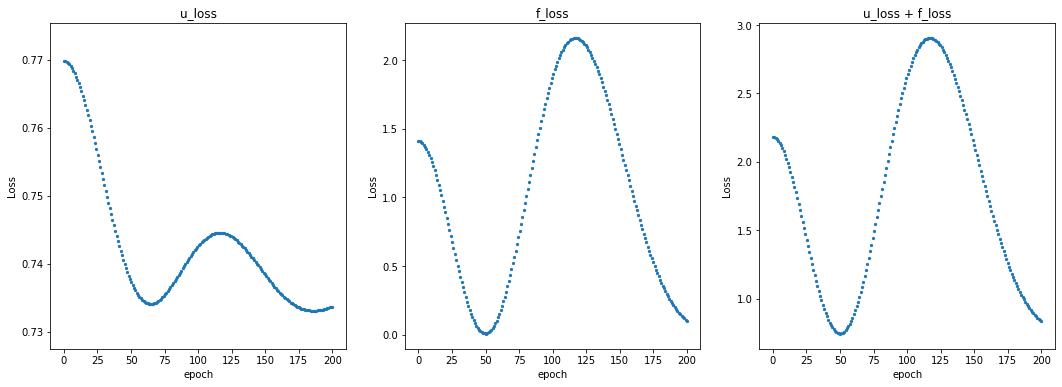

In [69]:
fig, axs = plt.subplots(1,3,figsize=(18,6))
# c_inference
epoch = np.linspace(0,loss.shape[0],loss.shape[0])

axs[0].set_title("u_loss")
axs[0].set_ylabel("Loss")
axs[0].set_xlabel("epoch")
axs[0].scatter(epoch[:],loss['u_loss'], s=5) 

axs[1].set_title("f_loss")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("epoch")
axs[1].scatter(epoch[:],loss['f_loss'], s=5) 

axs[2].set_title("u_loss + f_loss")
axs[2].set_ylabel("Loss")
axs[2].set_xlabel("epoch")
axs[2].scatter(epoch[:],loss['u_loss+f_loss'], s=5) 

plt.savefig("loss.png")


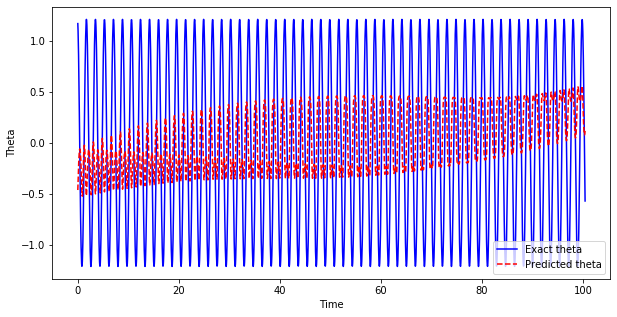

In [70]:
u_pred, f_pred = pinn.predict(X_star)
plt.figure(figsize=(10,5))
plt.plot(X_star[:,1],u_star, "b-", label = "Exact theta")
plt.plot(X_star[:,1],u_pred*10, "r--", label="Predicted theta")
plt.ylabel("Theta")
plt.xlabel("Time")
plt.legend()
plt.savefig("pred+exact.png")

In [52]:
results = np.vstack((u_star.T,np.array(u_pred*10).T))

No handles with labels found to put in legend.


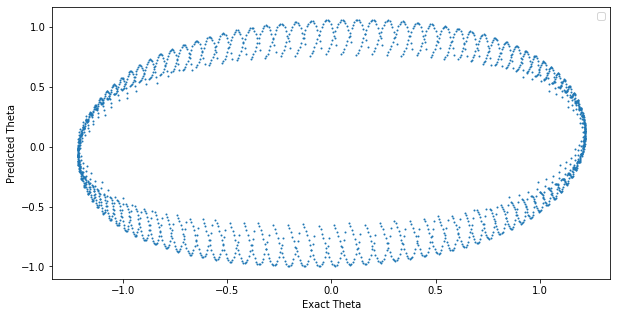

In [15]:
u_pred, f_pred = pinn.predict(X_star)
plt.figure(figsize=(10,5))
plt.scatter(results[0],results[1],s=1)
plt.ylabel("Predicted Theta")
plt.xlabel("Exact Theta")
plt.legend()
plt.savefig("pred_vs_exact.png")